In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cell2location
import scvi
from scipy.io import mmread
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0


In [2]:
results_folder = '../results/analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures_liver'
run_name = f'{results_folder}/cell2location_map_liver'

In [3]:
slide_name='HCC-1T'
adata_file = f"{run_name}/{slide_name}.h5ad"
adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{new_run_name}", adata_vis)

In [4]:
adata_vis

AnnData object with n_obs × n_vars = 3184 × 16365
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [5]:
adata_vis.obsm['q05_cell_abundance_w_sf']

q05cell_abundance_w_sf_ASC  q05cell_abundance_w_sf_B  \
AAACAAGTATCTCCCA-1                    0.227337                  0.031394   
AAACACCAATAACTGC-1                    1.011216                  0.124633   
AAACAGCTTTCAGAAG-1                    0.425555                  0.109289   
AAACAGGGTCTATATT-1                    1.432631                  0.089414   
AAACATGGTGAGAGGA-1                    1.010717                  0.087281   
...                                        ...                       ...   
TTGTTCAGTGTGCTAC-1                    0.073666                  0.032178   
TTGTTGTGTGTCAAGA-1                    0.323098                  0.049992   
TTGTTTCACATCCAGG-1                    0.242535                  0.030618   
TTGTTTCATTAGTCTA-1                    0.436167                  0.028166   
TTGTTTCCATACAACT-1                    0.059990                  0.046856   

                    q05cell_abundance_w_sf_CD4+ T  \
AAACAAGTATCTCCCA-1                       0.091611   
AAACACCAATAACTGC-1                       0.041695   
AAACAGCTTTCAGAAG-1                       0.083699   
AAACAGGGTCTATATT-1                       0.049306   
AAACATGGTGAGAGGA-1                       0.049116   
...                                           ...   
TTGTTCAGTGTGCTAC-1                       0.025770   
TTGTTGTGTGTCAAGA-1                       0.045808   
TTGTTTCACATCCAGG-1                       0.015538   
TTGTTTCATTAGTCTA-1                       0.010667   
TTGTTTCCATACAACT-1                       0.117352   

                    q05cell_abundance_w_sf_CD8+ T  \
AAACAAGTATCTCCCA-1                       0.077713   
AAACACCAATAACTGC-1                       0.027615   
AAACAGCTTTCAGAAG-1                       0.083653   
AAACAGGGTCTATATT-1                       0.026732   
AAACATGGTGAGAGGA-1                       0.024719   
...                                           ...   
TTGTTCAGTGTGCTAC-1                       0.025687   
TTGTTGTGTGTCAAGA-1                       0.028690   
TTGTTTCACATCCAGG-1                       0.011691   
TTGTTTCATTAGTCTA-1                       0.008893   
TTGTTTCCATACAACT-1                       0.059444   

                    q05cell_abundance_w_sf_Dendritic  \
AAACAAGTATCTCCCA-1                          0.051167   
AAACACCAATAACTGC-1                          0.009995   
AAACAGCTTTCAGAAG-1                          0.713156   
AAACAGGGTCTATATT-1                          0.065406   
AAACATGGTGAGAGGA-1                          0.009807   
...                                              ...   
TTGTTCAGTGTGCTAC-1                          0.052227   
TTGTTGTGTGTCAAGA-1                          0.077204   
TTGTTTCACATCCAGG-1                          0.074829   
TTGTTTCATTAGTCTA-1                          0.015338   
TTGTTTCCATACAACT-1                          0.172028   

                    q05cell_abundance_w_sf_Endothelial  \
AAACAAGTATCTCCCA-1                            1.073466   
AAACACCAATAACTGC-1                            0.102696   
AAACAGCTTTCAGAAG-1                            0.389654   
AAACAGGGTCTATATT-1                            0.202386   
AAACATGGTGAGAGGA-1                            0.100867   
...                                                ...   
TTGTTCAGTGTGCTAC-1                            0.343140   
TTGTTGTGTGTCAAGA-1                            0.557320   
TTGTTTCACATCCAGG-1                            0.102458   
TTGTTTCATTAGTCTA-1                            0.241267   
TTGTTTCCATACAACT-1                            0.769711   

                    q05cell_abundance_w_sf_Epithelial  \
AAACAAGTATCTCCCA-1                           6.047661   
AAACACCAATAACTGC-1                          10.765981   
AAACAGCTTTCAGAAG-1                           9.221374   
AAACAGGGTCTATATT-1                          10.920857   
AAACATGGTGAGAGGA-1                          11.019018   
...                                               ...   
TTGTTCAGTGTGCTAC-1                           7.765527   
TTGTTGT

In [6]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.2)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

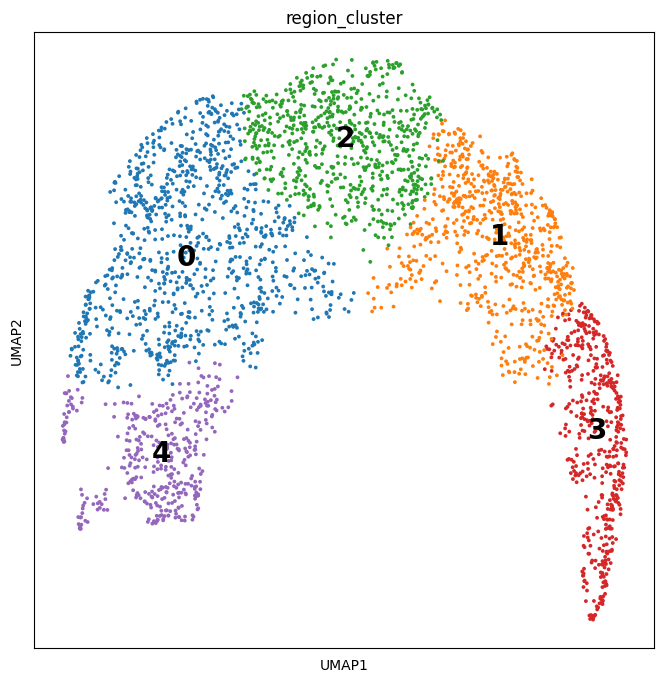

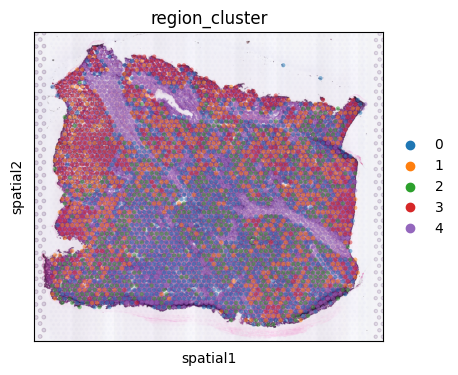

In [7]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
#     sc.pl.umap(adata_vis, color=['sample'], size=30,
#                color_map = 'RdPu', ncols = 2,
#                legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

In [8]:
adata_vis.obs["region_cluster"]

AAACAAGTATCTCCCA-1    4
AAACACCAATAACTGC-1    3
AAACAGCTTTCAGAAG-1    1
AAACAGGGTCTATATT-1    3
AAACATGGTGAGAGGA-1    3
                     ..
TTGTTCAGTGTGCTAC-1    2
TTGTTGTGTGTCAAGA-1    2
TTGTTTCACATCCAGG-1    0
TTGTTTCATTAGTCTA-1    0
TTGTTTCCATACAACT-1    0
Name: region_cluster, Length: 3184, dtype: category
Categories (5, object): ['0', '1', '2', '3', '4']

In [9]:
name=list(adata_vis.uns['spatial'].keys())[0]

In [10]:
adata_vis

AnnData object with n_obs × n_vars = 3184 × 16365
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels', 'leiden', 'region_cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial', 'neighbors', 'leiden', 'umap', 'region_cluster_colors'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf', 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
adata_vis.obs['sample']=name

In [12]:
types=['ASC',
 'B',
 'CD4+ T',
 'CD8+ T',
 'Dendritic',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'ILC',
 'MAIT',
 'MZB',
 'Macrophage',
 'Mast',
 'Mature B',
 'Memory B',
 'Mono',
 'NK',
 'NKT',
 'Naive B',
 'Plasma B',
 'Treg']

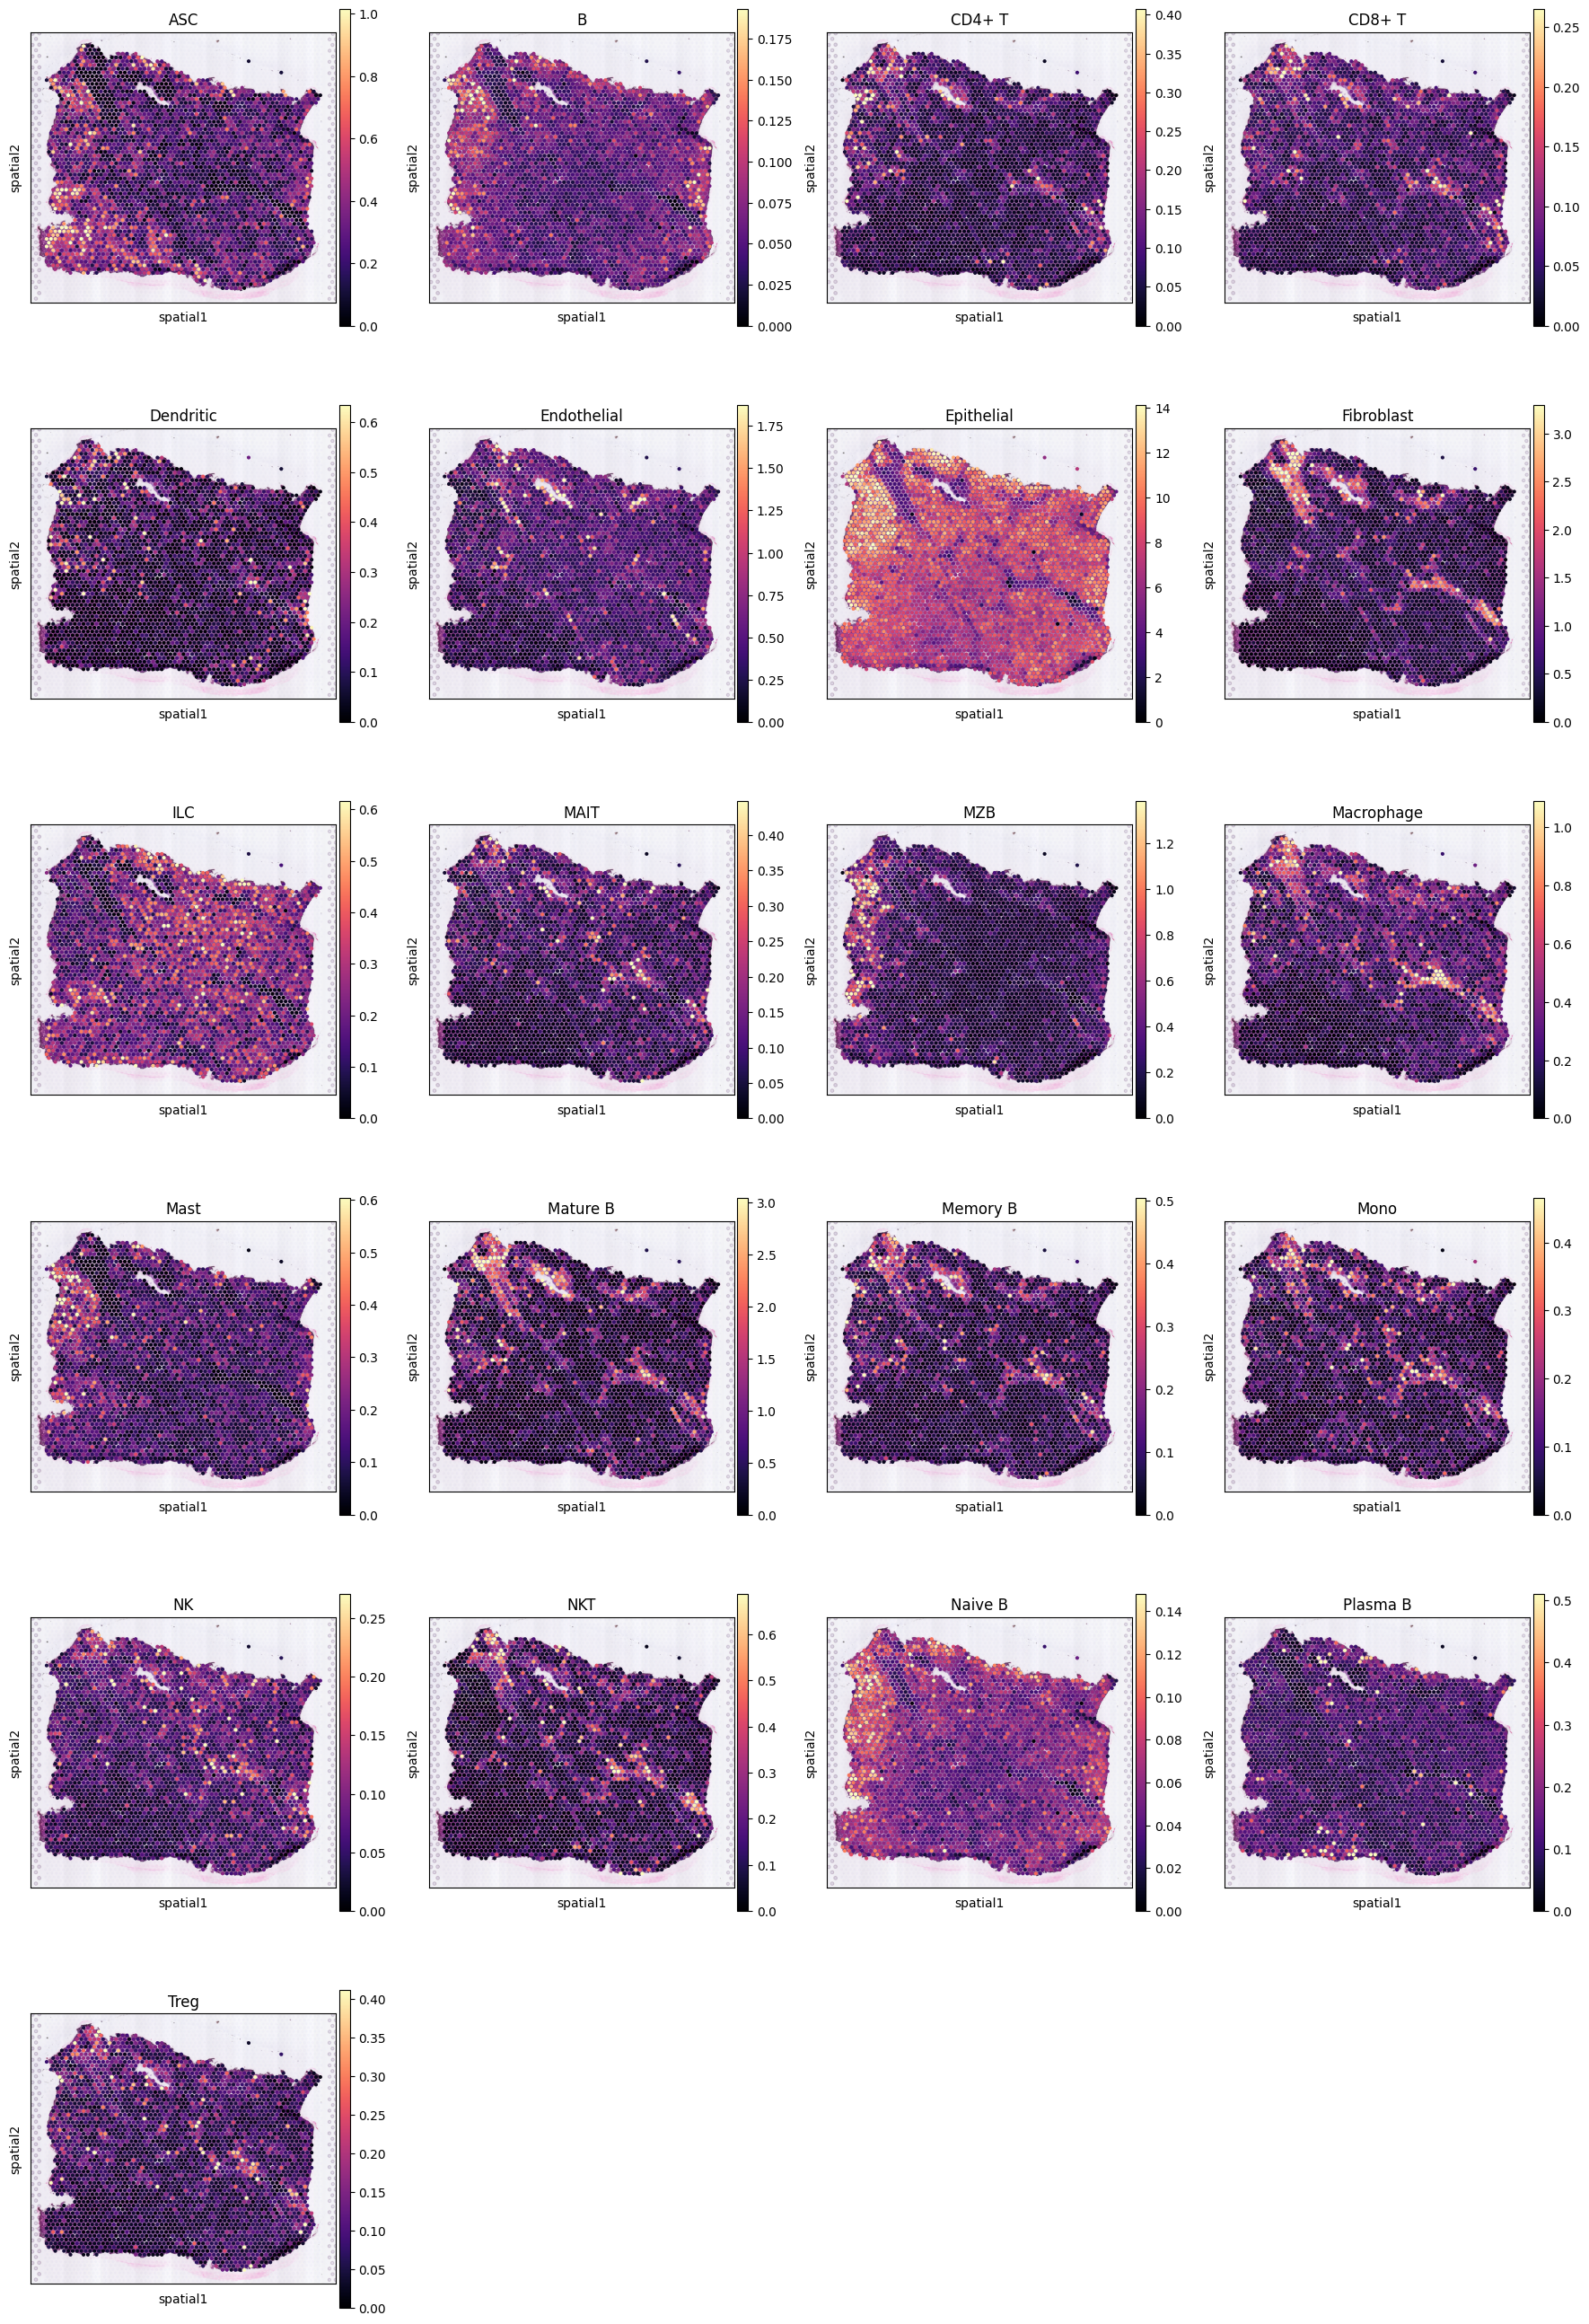

In [13]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, name)
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=types, 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  save=f'cell2loc_{slide_name}.png'
                 )
plt.show()

# Cells of each cluster

In [30]:
spot2cell_q05_class0=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='0')]
spot2cell_q05_class1=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='1')]
spot2cell_q05_class2=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='2')]
spot2cell_q05_class3=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='3')]
spot2cell_q05_class4=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='4')]
spot2cell_q05_class5=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='5')]
spot2cell=[spot2cell_q05_class0,spot2cell_q05_class1,spot2cell_q05_class2,spot2cell_q05_class3,spot2cell_q05_class4,spot2cell_q05_class5]

In [31]:
spot2cell_q05_class0.columns

Index(['q05cell_abundance_w_sf_ASC', 'q05cell_abundance_w_sf_B',
       'q05cell_abundance_w_sf_CD4+ T', 'q05cell_abundance_w_sf_CD8+ T',
       'q05cell_abundance_w_sf_Dendritic',
       'q05cell_abundance_w_sf_Endothelial',
       'q05cell_abundance_w_sf_Epithelial',
       'q05cell_abundance_w_sf_Fibroblast', 'q05cell_abundance_w_sf_ILC',
       'q05cell_abundance_w_sf_MAIT', 'q05cell_abundance_w_sf_MZB',
       'q05cell_abundance_w_sf_Macrophage', 'q05cell_abundance_w_sf_Mast',
       'q05cell_abundance_w_sf_Mature B', 'q05cell_abundance_w_sf_Memory B',
       'q05cell_abundance_w_sf_Mono', 'q05cell_abundance_w_sf_NK',
       'q05cell_abundance_w_sf_NKT', 'q05cell_abundance_w_sf_Naive B',
       'q05cell_abundance_w_sf_Plasma B', 'q05cell_abundance_w_sf_Treg'],
      dtype='object')

In [32]:
spot2cell_q05_class0.columns=types
spot2cell_q05_class1.columns=types
spot2cell_q05_class2.columns=types
spot2cell_q05_class3.columns=types
spot2cell_q05_class4.columns=types
spot2cell_q05_class5.columns=types

In [33]:
spot2cell_q05_class0.columns

Index(['ASC', 'B', 'CD4+ T', 'CD8+ T', 'Dendritic', 'Endothelial',
       'Epithelial', 'Fibroblast', 'ILC', 'MAIT', 'MZB', 'Macrophage', 'Mast',
       'Mature B', 'Memory B', 'Mono', 'NK', 'NKT', 'Naive B', 'Plasma B',
       'Treg'],
      dtype='object')

In [34]:
# for i in range(4):
#     spot2cell[i].to_csv('spot2cell_q05_class_4_'+str(i)+'.csv')

In [40]:
npclass0=np.array(spot2cell_q05_class0)
npclass1=np.array(spot2cell_q05_class1)
npclass2=np.array(spot2cell_q05_class2)
npclass3=np.array(spot2cell_q05_class3)
npclass4=np.array(spot2cell_q05_class4)
npclass5=np.array(spot2cell_q05_class5)

In [38]:
np.arange(0,21)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [42]:
npmean0=np.mean(npclass0,axis=0)
npmean1=np.mean(npclass1,axis=0)
npmean2=np.mean(npclass2,axis=0)
npmean3=np.mean(npclass3,axis=0)

In [45]:
npmean0

array([0.31433808, 0.04904057, 0.05243098, 0.06836304, 0.09184759,
       0.45860532, 4.75602076, 1.07822231, 0.07349776, 0.04911965,
       0.42741002, 0.16164158, 0.06752038, 1.99980843, 0.1154691 ,
       0.09416923, 0.03833186, 0.36155648, 0.05183443, 0.16839624,
       0.0599334 ])

In [47]:
x=np.arange(0,21)
cells=[[],[],[],[]]
fig = plt.figure(figsize=(8,6), dpi=140)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(x,npmean0,'o',markersize=3)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(x,npmean1,'o',markersize=3)
ax3 = plt.subplot(2, 2, 3)
ax3.plot(x,npmean2,'o',markersize=3)
ax4 = plt.subplot(2, 2, 4)
ax4.plot(x,npmean3,'o',markersize=3)
for i in range(len(npmean0)):
    if npmean0[i]>=0.1:
        ax1.text(i,npmean0[i],types[i],size=5)
        cells[0].append(type[i])
for i in range(len(npmean0)):
    if npmean1[i]>=0.1:
        ax2.text(i,npmean1[i],types[i],size=5)
        cells[1].append(type[i])
for i in range(len(npmean0)):
    if npmean2[i]>=0.1:
        ax3.text(i,npmean2[i],types[i],size=5)
        cells[2].append(type[i])
for i in range(len(npmean0)):
    if npmean3[i]>=0.1:
        ax4.text(i,npmean3[i],types[i],size=5)
        cells[3].append(type[i])
